# CPU and GPU logging demo
This repo and notebook are a rework of Scott Lowe's script to track the CPU and GPU utilisation in an NVIDIA GPU compute environment. Much of the technique was created and described by Scott and duplicated here. This work was to package the tool into a class that could be included in a project.

## Running simulated computation on CPU and GPU  

This notebook uses Torch to do matrix multiplication repeatedly in a simulation of useful computation. We're going to do adds, multiplies, and matrix multiplies with matrices of different sizes. As the size increases, the number of operations to be simultaneously performed increases. We can see that the CPU is faster with small matrices, but the GPU has so many threads available to it that there is virtually no penalty for increasing the size of the matrix up to a certain point. If you change the option over to random floats instead of ones, you'll see a big slow down due to the increase in time generating the matrices. I haven't investigated half/double precision here because Pytorch doesn't support it on CPU.

Because there is a large disparity in the rate at which iterations can be performed, we fix the duration of compute and see how many iterations could be achieved in that timespan.

In [1]:
import os
import time

import numpy as np
import torch

import nvidia_profiler

In [2]:
def program_under_test():
    """Example Torch CPU and GPU program"""
    t_per_exp = 2
    t_sleep = 2
    matrix_shapes = [(8, 8), (64, 64), (512, 512), (4096, 4096)]
    tgen_list = [
        ("ones_float", lambda s, d: torch.ones(s, dtype=torch.float, device=d)),
    ]
    op_list = [
        ("ADD", lambda x, y: x + y),
        ("MUL", lambda x, y: x * y),
        ("MATMUL", lambda x, y: torch.matmul(x, y)),
    ]

    # Do some compute on CPU and GPU
    for tensor_source in ['static inputs', 'regenerated inputs']:
        for tgen_name, tgen_fn in tgen_list:
            print(f"Tensor Source: {tensor_source}")
            print(f"Using {tgen_name}")
            for op_name, op_fun in op_list:
                op_message = f"{op_name} operations"
                print("\n" + op_message + f"\n{'-'*len(op_message)}")
                time.sleep(5)
                for device in ["cpu", "cuda"]:
                    for shp in matrix_shapes:
                        pad2 = ""
                        print(f"{pad2}Beginning {str(shp)} {tgen_name} {op_name} "
                              f"operations on {device.upper()} for {t_per_exp}s ({tensor_source})"
                             )
                        i = 0
                        t_start = time.time()
                        t_gen = 0
                        t_op = 0
                        if tensor_source == 'static inputs':
                            x = tgen_fn(shp, device)
                            y = tgen_fn(shp, device)
                        while time.time() - t_start < t_per_exp:
                            t0 = time.time()
                            if tensor_source == 'regenerated inputs':
                                x = tgen_fn(shp, device)
                                y = tgen_fn(shp, device)
                            t1 = time.time()
                            t_gen += t1 - t0
                            z = op_fun(x, y)
                            t_op += time.time() - t1
                            i += 1
                        dt = time.time() - t_start
                        it_s = i/dt
                        gen_percent = 100 * t_gen / (t_gen + t_op + 0.001)
                        pad4 = " > "
                        print(f"{pad4}Completed {i} iterations in {dt:.1f}s ({it_s:10.3f} it/s) "
                            f"with {gen_percent:.1f}% of time generating tensors")
                        time.sleep(t_sleep)

## 1. Instance the profiler  

In [3]:
nvidia_profiler.Logger?

Init signature:
nvidia_profiler.Logger(
    fp_output_filename=None,
    fp_output_directory=None,
    fname_timestamp=None,
    refresh_interval=0.05,
    iter_limit=None,
    show_header=True,
    show_units=True,
)
Docstring:     
A class that represents a thread of control.

This class can be safely subclassed in a limited fashion. There are two ways
to specify the activity: by passing a callable object to the constructor, or
by overriding the run() method in a subclass.
Init docstring:
Record CPU and NVIDIA GPU usage

Parameters
----------
fp_output_filename : str, prefix or whole filename to write data to
fp_output_directory : str, path to write data to. Defaults to current
fname_timestamp : str, timestamp to include in the output filename. Generated if not set.
refresh_interval : float, interval in seconds to sample data. Defaults to 0.05.
iter_limit : int, limit on how many iterations to run. Defaults to None.
show_header: bool, write header in output file
show_units : bool, wr

In [4]:
profiler = nvidia_profiler.Logger(fp_output_filename='test_data')

## 2. Run the profiler and program to test  
We start the profiler first to start the background process and record data, then the program to profile and finally stop the background recording.

In [5]:
profiler.run_threaded()

program_under_test()

profiler.stop()

Tensor Source: static inputs
Using ones_float

ADD operations
--------------
Beginning (8, 8) ones_float ADD operations on CPU for 2s (static inputs)
 > Completed 560868 iterations in 2.0s (280433.599 it/s) with 5.5% of time generating tensors
Beginning (64, 64) ones_float ADD operations on CPU for 2s (static inputs)
 > Completed 390021 iterations in 2.0s (195010.477 it/s) with 4.2% of time generating tensors
Beginning (512, 512) ones_float ADD operations on CPU for 2s (static inputs)
 > Completed 22927 iterations in 2.0s ( 11463.348 it/s) with 0.3% of time generating tensors
Beginning (4096, 4096) ones_float ADD operations on CPU for 2s (static inputs)
 > Completed 85 iterations in 2.0s (    42.300 it/s) with 0.0% of time generating tensors
Beginning (8, 8) ones_float ADD operations on CUDA for 2s (static inputs)
 > Completed 139730 iterations in 2.0s ( 69864.808 it/s) with 1.9% of time generating tensors
Beginning (64, 64) ones_float ADD operations on CUDA for 2s (static inputs)
 > C

## 3. Plot CPU and GPU data  
The recorded data file name is in the `fname` attribute.  
The `plot_data` function takes the CSV file and returns a matplotlib figure.

In [6]:
profiler.fname

'test_data-2023_11_21-04_53_06-timing.csv'

In [7]:
nvidia_profiler.plot_data?

Signature: nvidia_profiler.plot_data(fp, **kwargs)
Docstring:
Plot SMI data

Parameters
----------
fp : str, filepath to csv data file
kwargs : any Pandas plot keyword argument
File:      ~/nvidia_profiler.py
Type:      function

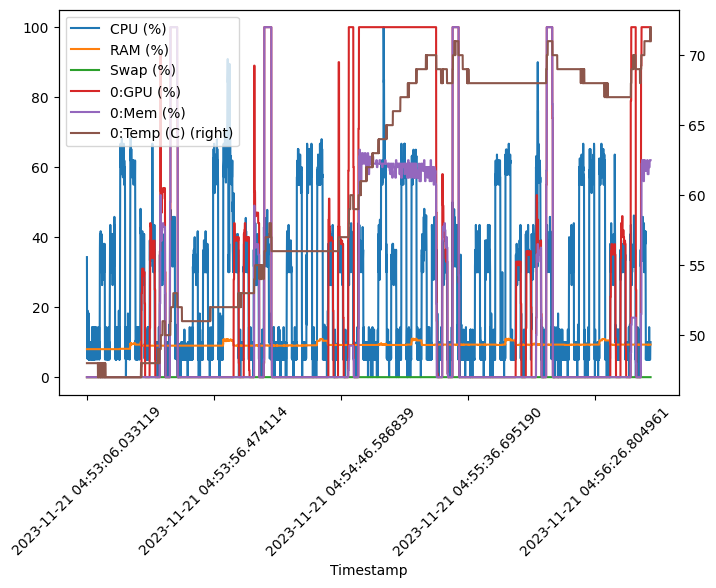

In [8]:
nvidia_profiler.plot_data(profiler.fname, figsize=(8, 5), rot=45)